In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Kalman filter for smoothing noisy sensor measurements
# will evaluate updating to IMM later

In [4]:
def xls_b26_to_b10(x):
    # TODO: check for anything other than [a-z]    
    zero_offset = 96        # make offset from ord('a') > 0
    col_num = -1            # automatically covert for 0 to 1 based
    b26 = 26                # 'a-z' is base 26
    
    # make lower and reverse order
    x = x.lower()[::-1]
    
    # get each value at each power of base 26
    b26_vals = [b26**(i)*(ord(j) - zero_offset) for i, j in enumerate(x)]
    
    # add base 26 power values to column number and return
    col_num += np.array(b26_vals).sum()
    
    return col_num

In [7]:
# init data to be processed
f_name = "2017_07_27 Operating data.xlsx"
sheet_plg = 'Pivot LG'
sheet_beq = 'BW ES QSee'

# extract data to dataframe
df_plg = pd.read_excel(f_name, sheet_plg)
df_beq = pd.read_excel(f_name, sheet_beq)

In [54]:
# extract data labels
df_plg_labels = list(df_plg)
df_beq_labels = list(df_beq)
date = {"plg":df_plg_labels[0], "beq":df_beq_labels[0]}
# system inputs
avg_temp = {"plg":df_plg_labels[2], "beq":df_beq_labels[xls_b26_to_b10('M')]}
avg_pres = {"plg":df_plg_labels[3], "beq":df_beq_labels[xls_b26_to_b10('G')]}
# system outputs
norm_perm_flow = {"plg":df_plg_labels[5], "beq":df_beq_labels[xls_b26_to_b10('AD')]}
perm_flow = df_beq_labels[xls_b26_to_b10('F')]
norm_salt = {"plg":df_plg_labels[6], "beq":df_beq_labels[xls_b26_to_b10('AE')]}
salt_numer = df_beq_labels[xls_b26_to_b10('V')]
salt_denom = df_beq_labels[xls_b26_to_b10('X')]

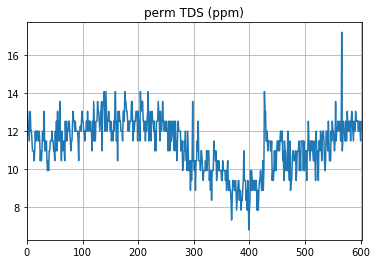

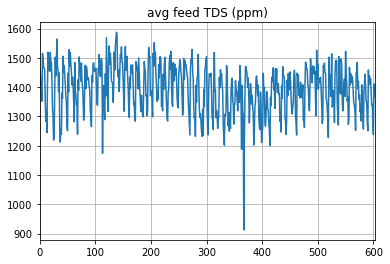

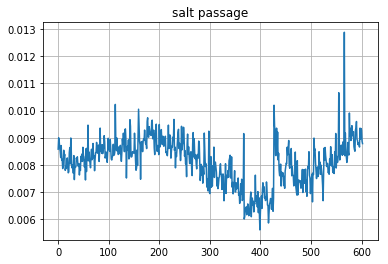

In [73]:
salt_passage = df_beq[salt_numer].values/df_beq[salt_denom].values

plt.figure()
df_beq[salt_numer].plot()
plt.title('perm TDS (ppm)')
plt.grid()

plt.figure()
df_beq[salt_denom].plot()
plt.title('avg feed TDS (ppm)')
plt.grid()

plt.figure()
plt.plot(salt_passage)
plt.title('salt passage')
plt.grid()

plt.show()

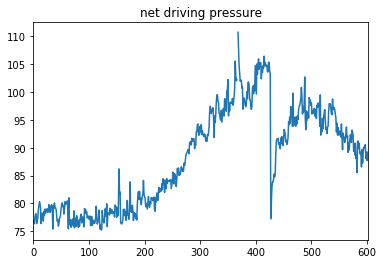

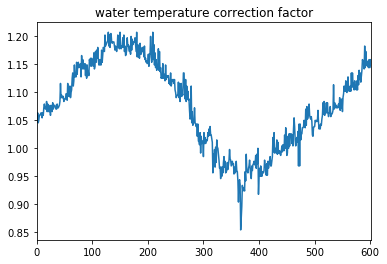

In [65]:
len(df_beq[date["beq"]])
plt.close('all')
plt.figure()
df_beq[df_beq_labels[xls_b26_to_b10('aa')]].plot()
plt.title('net driving pressure')
plt.figure()
df_beq[df_beq_labels[xls_b26_to_b10('n')]].plot()
plt.title('water temperature correction factor')
plt.figure()
df_beq[df_beq_labels[salt_numer].values/df_beq_labels[salt_denom].values].plot()
plt.title('salt passage')
plt.show()

In [43]:
# characterize data for Kalman filter
pres_noisy = df_beq[avg_pres["beq"]].values
# estimate measurement variance
var_pres_noisy = np.var(pres_noisy)

x0 = df_beq[date["beq"]].values[0]
x1 = pd.to_datetime(x0)
y0 = df_beq[df_beq_labels[xls_b26_to_b10('B')]].values[0]
#y1 = pd.to_datetime(y0)
for z in (x0, x1, y0):
    print type(z), z

<type 'numpy.datetime64'> 2016-05-06T00:00:00.000000000
<class 'pandas._libs.tslib.Timestamp'> 2016-05-06 00:00:00
<type 'datetime.time'> 12:30:00


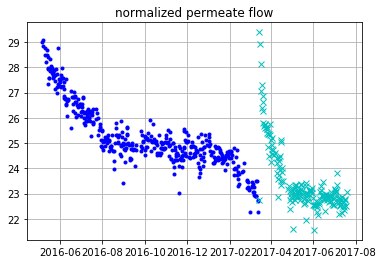

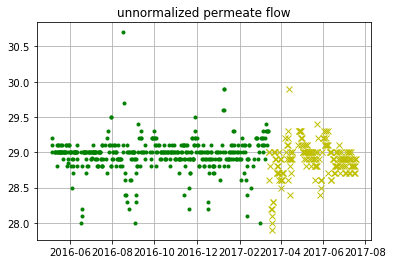

In [68]:
# scatter plot relation between
date0 = df_beq[df_beq[date["beq"]] < '2017-3-15'][date["beq"]].values
date1 = df_beq[df_beq[date["beq"]] >= '2017-3-15'][date["beq"]].values
nflow0 = df_beq[df_beq[date["beq"]] < '2017-3-15'][norm_perm_flow["beq"]].values
nflow1 = df_beq[df_beq[date["beq"]] >= '2017-3-15'][norm_perm_flow["beq"]].values
flow0 = df_beq[df_beq[date["beq"]] < '2017-3-15'][perm_flow].values
flow1 = df_beq[df_beq[date["beq"]] >= '2017-3-15'][perm_flow].values
plt.close('all')
plt.figure()
plt.plot(date0, nflow0, 'b.')
plt.plot(date1, nflow1, 'cx')
plt.title('normalized permeate flow')
plt.grid()
plt.figure()
plt.plot(date0, flow0, 'g.')
plt.plot(date1, flow1, 'yx')
plt.title('unnormalized permeate flow')
plt.grid()
plt.show()

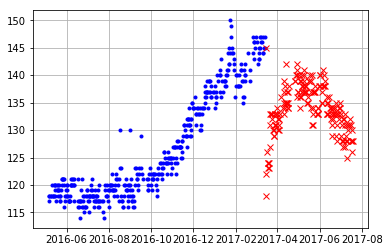

118


In [55]:
# scatter plot relation between
date0 = df_beq[df_beq[date["beq"]] < '2017-3-15'][date["beq"]].values
date1 = df_beq[df_beq[date["beq"]] >= '2017-3-15'][date["beq"]].values
pres0 = df_beq[df_beq[date["beq"]] < '2017-3-15'][avg_pres["beq"]].values
pres1 = df_beq[df_beq[date["beq"]] >= '2017-3-15'][avg_pres["beq"]].values
plt.close('all')
plt.figure()
plt.plot(date0, pres0, 'b.')
plt.plot(date1, pres1, 'rx')
plt.grid()
plt.show()

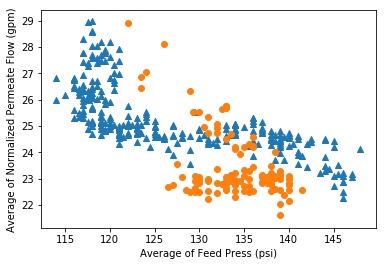

In [47]:
plt.close('all')

pres0 = df_plg[df_plg[date["plg"]] < '2017-3-15'][avg_pres["plg"]].values
pres1 = df_plg[df_plg[date["plg"]] > '2017-3-15'][avg_pres["plg"]].values
flow0 = df_plg[df_plg[date["plg"]] < '2017-3-15'][norm_perm_flow["plg"]].values
flow1 = df_plg[df_plg[date["plg"]] > '2017-3-15'][norm_perm_flow["plg"]].values

plt.figure()
plt.scatter(pres0, flow0, marker='^')
plt.scatter(pres1, flow1, marker='o')
plt.xlabel(avg_pres["plg"])
plt.ylabel(norm_perm_flow["plg"])
plt.show()

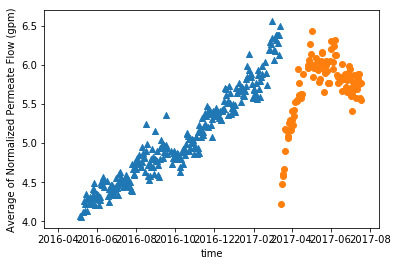

In [74]:
plt.close('all')

date0 = df_plg[df_plg[date["plg"]] < '2017-3-15'][date["plg"]].values
date1 = df_plg[df_plg[date["plg"]] > '2017-3-15'][date["plg"]].values
pres0 = df_plg[df_plg[date["plg"]] < '2017-3-15'][avg_pres["plg"]].values
pres1 = df_plg[df_plg[date["plg"]] > '2017-3-15'][avg_pres["plg"]].values
flow0 = df_plg[df_plg[date["plg"]] < '2017-3-15'][norm_perm_flow["plg"]].values
flow1 = df_plg[df_plg[date["plg"]] > '2017-3-15'][norm_perm_flow["plg"]].values

plt.figure()
plt.scatter(date0, pres0/flow0, marker='^')
plt.scatter(date1, pres1/flow1, marker='o')
plt.xlabel("time")
plt.ylabel(norm_perm_flow["plg"])
plt.show()

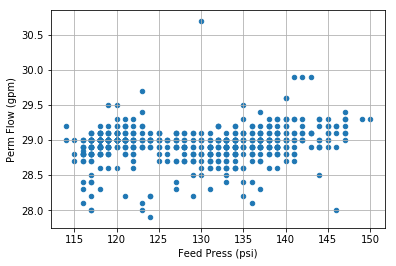

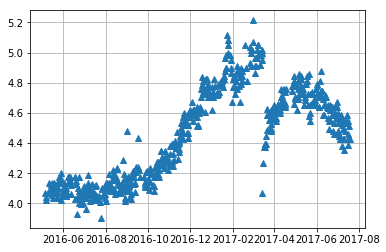

In [78]:
# scatter plot relation betweew
plt.close('all')

plt.figure()
df_beq.plot(x=avg_pres["beq"], y=perm_flow, kind='scatter')
plt.grid()

plt.figure()
numer = df_beq[avg_pres["beq"]].values
denom = df_beq[perm_flow].values
date_ = df_beq[date["beq"]].values
plt.plot(date_, numer/denom, '^')
plt.grid()

plt.show()